In [1]:
import pandas as pd 
import numpy as np
import statistics
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.arima_process as arima_process 

from numpy import cov
from random import shuffle 
from category_encoders import TargetEncoder

from matplotlib.pyplot import figure
from matplotlib import pyplot
import matplotlib.pyplot as plt

#from sklearn.preprocessing import StandardScalar
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.inspection import permutation_importance


from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend, seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_columns", None)
df = pd.read_csv("/Users/lois/Desktop/ML/Module 11/practical_application_II_starter/data/vehicles.csv")
df.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl


In [168]:
df.dropna(subset=['year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission'], inplace = True) 

In [169]:
#imputing 
df["condition"].fillna(df["condition"].mode().to_string(), inplace = True)
df["cylinders"].fillna(df["cylinders"].mode().to_string(), inplace = True)
df["drive"].fillna(df["drive"].mode().to_string(), inplace = True)
df["size"].fillna(df["size"].mode().to_string(), inplace = True)
df["type"].fillna(df["type"].mode().to_string(), inplace = True)
df["paint_color"].fillna(df["paint_color"].mode().to_string(), inplace = True)

#df.isna().sum()

In [170]:
#encoding
te = TargetEncoder()
encoded_df = te.fit_transform(df[["region", "manufacturer", "model", "type", "paint_color", "state", "fuel", "drive", "transmission"]], df["price"])

In [171]:
df.drop(['region', 'manufacturer', 'model', 'type', 'paint_color', 'state',
       'fuel', 'drive', 'transmission'], axis = 1, inplace = True)
df = pd.concat([df, encoded_df], axis = 1)
df.shape

(389604, 18)

In [172]:
#ordinal col

df = df[df["size"] != '0    4']
df["size"].replace({"0    full-size" : 4, "full-size" : 4, "mid-size" : 3, "compact" : 2, "sub-compact" : 1}, inplace = True)

df["paint_color"].replace({"0    white" : "white"}, inplace = True)

df = df[df["condition"] != '0    good']
df["condition"].replace({"new" : 6, "excellent" : 5, "like new" : 4, "good" : 3, "fair" : 2, "salvage" : 1}, inplace = True)

#converting values to Int
df["condition"] = df["condition"].astype(int)

df = df[df["cylinders"] != "0    6"]
df["cylinders"].replace({"8 cylinders" : 8, "6 cylinders" : 6, "0    6 cylinders" : 6, \
                         "5 cylinders" : 5, "4 cylinders" : 4, "10 cylinders" : 10, \
                         "3 cylinders" : 3, "12 cylinders" : 12, "other" : 6}, inplace = True)

df["title_status"].replace({"clean" : 6, "lien" : 5, "rebuilt" : 4, "missing" : 3, "salvage" : 2, "parts only" : 1}, inplace = True)


In [173]:
df = df.convert_dtypes()

In [174]:
#filter price
df = df[(df["price"] >= 150) & (df["price"] <= 70000)]

In [175]:
df.agg(["skew"]).transpose()

,skew
id,-0.630330
price,0.789593
year,-3.222202
condition,0.189426
cylinders,0.100428
odometer,43.495808
title_status,-5.945284
size,-2.572930
region,10.005744
manufacturer,3.092377


In [176]:
#log transform price column
df['price'] = np.log(df['price'])

#sns.distplot(df['price']).set(title = 'Log-Transformed Distribution of Price');

In [177]:
df['model'] = np.log(df['model'])

#sns.distplot(df['model']).set(title = 'Log-Transformed Distribution of Model');

In [149]:
#df['transmission'] = np.log(df['transmission'])

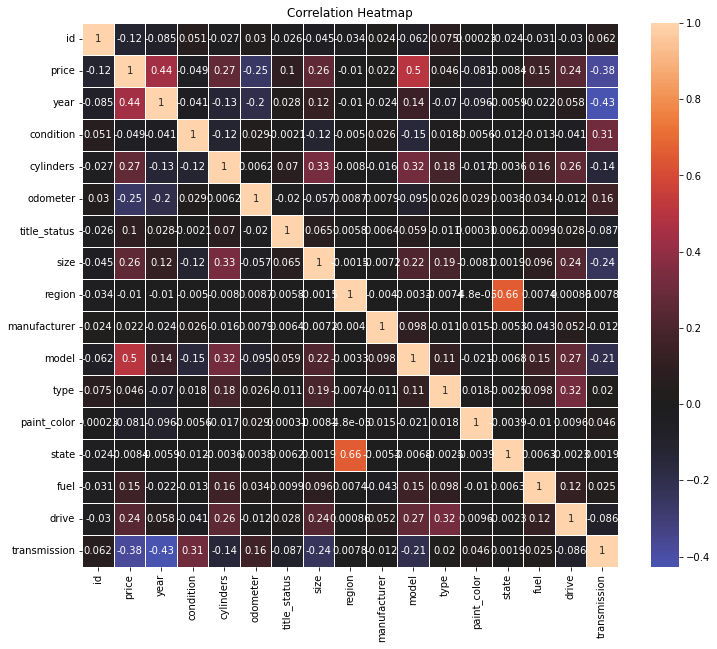

In [188]:
#correlation heatmap  

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(df.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

In [183]:
final_df = df[["year", "condition", "cylinders", "odometer", "title_status", "size", "model", "fuel", "drive", "transmission", "price"]]

In [184]:
#splitting data 
X = final_df.drop("price", axis = 1)
y = final_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

### Linear Regression
0.44

In [185]:
lr = LinearRegression(fit_intercept = True)
lr_model = lr.fit(X_train, y_train)
lr_mse = mean_squared_error(lr_model.predict(X_test), y_test)
print(f"MSE of linear regression model is {np.round(lr_mse, 2)}")

MSE of linear regression model is 0.44


### Pipeline PolynomialFeatures
Degree 3: 0.248

In [186]:
def get_MSE_for_degree_k_model(k):
    pipelined_model = Pipeline([
        ("transform", PolynomialFeatures(degree = k)),
        ("scaler", StandardScaler()),
        ("regression", LinearRegression(fit_intercept = True))
    ])
    pipelined_model.fit(X_train, y_train)
    return mean_squared_error(y_test, pipelined_model.predict(X_test))

In [187]:
ks = np.array(range(0, 8))
MSEs = get_MSE_for_degree_k_model(2) 
MSEs

0.2486975063434189

In [ ]:
#manual GridSearchCV on ridge
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

coefs = []
test_scores = []
test_mse = []

In [ ]:
for alpha in alphas:
    pipe = Pipeline([
        ("transform", PolynomialFeatures(degree = 4, include_bias = False)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha = alpha))
    ])
    pipe.fit(X_train, y_train)
    test_mse.append(mean_squared_error(y_test, pipe.predict(X_test)))
    test_scores.append(pipe.score(X_test, y_test))

In [ ]:
print(f"Best alpha: {alphas[test_mse.index(min(test_mse)) - 1]}")
print(f"Score: {pipe.score(X_test, y_test)}")